In [2]:
import psycopg2
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
from collections import defaultdict

# User Input Required

In [125]:
#Enter Regional Benchmark Name
region_name = 'Yorkshire and The Humber'

#Enter Local Authority Benchmark Name
local_authority_name = 'Leeds'

#Enter list of LSOAs for the study area
study_area_msoa_list = [
    "E02002367",
    "E02002371",
    "E02002373",
    "E02002383",
    "E02002384",
    "E02002385",
    "E02002392",
    "E02002393",
    "E02002400",
    "E02002411",
    "E02006861",
    "E02006875"
]

#Enter file path for saving images
image_path=r'N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs'

# 1. Connect to Geodatabase

In [126]:
# --- DB connection params ---
conn_params = {
    'host': 'PRIORPSRV03',
    'port': 5432,
    'dbname': 'gis',    
}

# --- Connect to Postgres ---
conn = psycopg2.connect(**conn_params)

# 2. Run SQL query to retrive required data

In [127]:
query = """
WITH selected_msoas AS (
    SELECT DISTINCT msoa11cd
    FROM uk_new.ohid_msoa2011_life_expectancy
)
SELECT 
    s.msoa11cd,
    le.*,       -- life expectancy table
    mo.*, 
    co.*, 
    ds.*, 
    un.*
FROM selected_msoas s
LEFT JOIN uk_new.ohid_msoa2011_life_expectancy             le  ON s.msoa11cd = le.msoa11cd
LEFT JOIN uk_new.ohid_msoa2011_mortality_rate             mo  ON s.msoa11cd = mo.msoa11cd
LEFT JOIN uk_new.ohid_msoa2011_childhood_obesity          co  ON s.msoa11cd = co.msoa11cd
LEFT JOIN uk_new.ohid_long_term_disability_and_illness    ds  ON s.msoa11cd = ds.msoa11cd
LEFT JOIN uk_new.ohid_unemployment                        un  ON s.msoa11cd = un.msoa11cd

"""

# --- Load the query result ---
uk = pd.read_sql_query(query, conn)
conn.close()

# --- Step 1: Find and keep only the first 'lsoa21cd' column ---
msoa_cols = [col for col in uk.columns if col.startswith('msoa11cd')]
first_msoa = msoa_cols[0]

# --- Step 2: Drop all duplicate metadata columns and keep only the first lsoa21cd ---
columns_to_drop = [
    col for col in uk.columns if col in [
        'FID', 'data_time_period', 'data_web_link',
        'msoa21cd', 'msoa21nm', 'wd22cd', 'wd22nm', 'area_ha',
        'data_source', 'lsoa21nm', 'data_resolution',
        'lad22cd','rgn22cd','geometry'
    ] or (col.startswith('lsoa21cd') and col != first_lsoa)
]

# Rename and clean
uk_health = uk.rename(columns={first_msoa: 'msoa11cd'})
uk_health = uk.drop(columns=columns_to_drop)

# View cleaned data
uk_health.head()

C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,msoa11cd,msoa11cd,msoa11nm,lad22nm,rgn22nm,female_population,male_population,male_life_expectancy,female_life_expectancy,avg_life_expectancy,national_benchmark_male,national_benchmark_female,national_benchmark_combined,msoa11cd,msoa11nm,lad22nm,rgn22nm,deaths_from_all_causes_all_ages_perc,deaths_from_all_causes_all_ages_count,deaths_from_all_causes_all_ages_denominator,deaths_from_all_causes_all_ages_under_75_years_perc,deaths_from_all_causes_all_ages_under_75_years_count,deaths_from_all_causes_all_ages_under_75_years_denominator,deaths_from_causes_considered_preventable_under_75_years_perc,deaths_from_causes_considered_preventable_under_75_years_count,deaths_from_causes_considered_preventable_under_75_years_denomi,deaths_from_all_cancer_all_ages_perc,deaths_from_all_cancer_all_ages_count,deaths_from_all_cancer_all_ages_denominator,deaths_from_all_cancer_under_75_years_perc,deaths_from_all_cancer_under_75_years_count,deaths_from_all_cancer_under_75_years_denominator,deaths_from_circulatory_disease_all_ages_perc,deaths_from_circulatory_disease_all_ages_count,deaths_from_circulatory_disease_all_ages_denominator,deaths_from_circulatory_disease_all_ages_under_75_years_perc,deaths_from_circulatory_disease_all_ages_under_75_years_count,deaths_from_circulatory_disease_all_ages_under_75_years_denomin,deaths_from_coronary_heart_disease_all_ages_perc,deaths_from_coronary_heart_disease_all_ages_count,deaths_from_coronary_heart_disease_all_ages_denominator,deaths_from_respiratory_diseases_all_ages_perc,deaths_from_respiratory_diseases_all_ages_count,deaths_from_respiratory_diseases_all_ages_denominator,deaths_from_stroke_perc,deaths_from_stroke_count,deaths_from_stroke_denominator,msoa11cd,msoa11nm,lad22nm,rgn22nm,reception_prevalence_of_obesity_perc,reception_prevalence_of_obesity_count,reception_prevalence_of_obesity_denominator,reception_prevalence_of_overweight_perc,reception_prevalence_of_overweight_count,reception_prevalence_of_overweight_denominator,year_6_prevalence_of_obesity_perc,year_6_prevalence_of_obesity_count,year_6_prevalence_of_obesity_denominator,year_6_prevalence_of_overweight_perc,year_6_prevalence_of_overweight_count,year_6_prevalence_of_overweight_denominator,msoa11cd,msoa11nm,lad22nm,rgn22nm,limiting_long_term_illness_or_disability_perc,limiting_long_term_illness_or_disability_count,limiting_long_term_illness_or_disability_denominator,msoa11cd,msoa11nm,lad22nm,rgn22nm,unemployment_perc,unemployment_count,unemployment_denominator,long_term_unemployment_rate_per_1000_working_age_population,long_term_unemployment_count,long_term_unemployment_denominator
0,E02000001,E02000001,City of London 001,City of London,London,3861.0,4722.0,90.368903,90.737293,90.534621,Above National Average,Above National Average,Above National Average,E02000001,City of London 001,City of London,London,50.247355,202.0,402.011213,61.290593,80.0,130.525739,71.472594,42.0,58.763783,65.183666,69.0,105.854740,67.478951,34.0,50.386082,55.775547,53.85,96.547687,64.748007,18.0,27.800083,73.347225,30.0,40.901343,36.508637,18.916,51.812397,35.621603,7.952,22.323532,E02000001,City of London 001,City of London,London,NaN,NaN,NaN,26.66667,20.0,75.0,14.28571,10.0,70.0,35.71429,25.0,70.0,E02000001,City of London 001,City of London,London,11.498305,848.0,7375.0,E02000001,City of London 001,City of London,London,3.675168,276.666667,7528.0,1.328374,10.00,7528.0
1,E02000002,E02000002,Barking and Dagenham 001,Barking and Dagenham,London,4362.0,3919.0,78.774088,81.704768,80.317818,Similar to National Average,Similar to National Average,Similar to National Average,E02000002,Barking and Dagenham 001,Barking and Dagenham,London,99.344041,343.0,345.264794,132.848007,105.0,79.037693,120.340653,42.5,35.316411,112.130843,89.0,79.371561,135.386944,39.0,28.806323,92.922057,77.83,83.758370,142.866305,23.0,16.098967,83.598469,28.0,33.493436,102.475182,46.804,45.673498,73.317476,14.792,20.175272,E02000002,Barking and Dagenham 001,Barking and Dagenham,London,12.67606,45.0,355.0

In [128]:
# save as csv so no need to run SQL query again to save time
uk_health.to_csv(r"N:\Geodatabase\Geodatabase Query Exports\uk_health.csv", index=False)

In [129]:
#reload data from csv
uk_health = pd.read_csv(r"N:\Geodatabase\Geodatabase Query Exports\uk_health.csv")

In [130]:
uk_health.columns.to_list()

['msoa11cd',
 'msoa11cd.1',
 'msoa11nm',
 'lad22nm',
 'rgn22nm',
 'female_population',
 'male_population',
 'male_life_expectancy',
 'female_life_expectancy',
 'avg_life_expectancy',
 'national_benchmark_male',
 'national_benchmark_female',
 'national_benchmark_combined',
 'msoa11cd.2',
 'msoa11nm.1',
 'lad22nm.1',
 'rgn22nm.1',
 'deaths_from_all_causes_all_ages_perc',
 'deaths_from_all_causes_all_ages_count',
 'deaths_from_all_causes_all_ages_denominator',
 'deaths_from_all_causes_all_ages_under_75_years_perc',
 'deaths_from_all_causes_all_ages_under_75_years_count',
 'deaths_from_all_causes_all_ages_under_75_years_denominator',
 'deaths_from_causes_considered_preventable_under_75_years_perc',
 'deaths_from_causes_considered_preventable_under_75_years_count',
 'deaths_from_causes_considered_preventable_under_75_years_denomi',
 'deaths_from_all_cancer_all_ages_perc',
 'deaths_from_all_cancer_all_ages_count',
 'deaths_from_all_cancer_all_ages_denominator',
 'deaths_from_all_cancer_under

In [141]:
columns_to_keep = [
    # Identifier
    'msoa11cd',
    'rgn22nm',
    'lad22nm',
    
    'female_population',
     'male_population',
     'male_life_expectancy',
     'female_life_expectancy',
     'avg_life_expectancy',
     'national_benchmark_male',
     'national_benchmark_female',
     'national_benchmark_combined',
     
     'reception_prevalence_of_obesity_perc',
     'reception_prevalence_of_obesity_count',
     'reception_prevalence_of_obesity_denominator',
     'reception_prevalence_of_overweight_perc',
     'reception_prevalence_of_overweight_count',
     'reception_prevalence_of_overweight_denominator',
     'year_6_prevalence_of_obesity_perc',
     'year_6_prevalence_of_obesity_count',
     'year_6_prevalence_of_obesity_denominator',
     'year_6_prevalence_of_overweight_perc',
     'year_6_prevalence_of_overweight_count',
     'year_6_prevalence_of_overweight_denominator',

     'limiting_long_term_illness_or_disability_perc',
     'limiting_long_term_illness_or_disability_count',
     'limiting_long_term_illness_or_disability_denominator',

     'unemployment_perc',
     'unemployment_count',
     'unemployment_denominator',
     'long_term_unemployment_rate_per_1000_working_age_population',
     'long_term_unemployment_count',
     'long_term_unemployment_denominator',
    
     'deaths_from_all_causes_all_ages_perc',
     'deaths_from_all_causes_all_ages_count',
     'deaths_from_all_causes_all_ages_denominator',
     'deaths_from_all_causes_all_ages_under_75_years_perc',
     'deaths_from_all_causes_all_ages_under_75_years_count',
     'deaths_from_all_causes_all_ages_under_75_years_denominator',
     'deaths_from_causes_considered_preventable_under_75_years_perc',
     'deaths_from_causes_considered_preventable_under_75_years_count',
     'deaths_from_causes_considered_preventable_under_75_years_denomi',
     'deaths_from_all_cancer_all_ages_perc',
     'deaths_from_all_cancer_all_ages_count',
     'deaths_from_all_cancer_all_ages_denominator',
     'deaths_from_all_cancer_under_75_years_perc',
     'deaths_from_all_cancer_under_75_years_count',
     'deaths_from_all_cancer_under_75_years_denominator',
     'deaths_from_circulatory_disease_all_ages_perc',
     'deaths_from_circulatory_disease_all_ages_count',
     'deaths_from_circulatory_disease_all_ages_denominator',
     'deaths_from_circulatory_disease_all_ages_under_75_years_perc',
     'deaths_from_circulatory_disease_all_ages_under_75_years_count',
     'deaths_from_circulatory_disease_all_ages_under_75_years_denomin',
     'deaths_from_coronary_heart_disease_all_ages_perc',
     'deaths_from_coronary_heart_disease_all_ages_count',
     'deaths_from_coronary_heart_disease_all_ages_denominator',
     'deaths_from_respiratory_diseases_all_ages_perc',
     'deaths_from_respiratory_diseases_all_ages_count',
     'deaths_from_respiratory_diseases_all_ages_denominator',
     'deaths_from_stroke_perc',
     'deaths_from_stroke_count',
     'deaths_from_stroke_denominator',
]


In [142]:
uk_health_df = uk_health[columns_to_keep]
uk_health_df.head()

,msoa11cd,rgn22nm,lad22nm,female_population,male_population,male_life_expectancy,female_life_expectancy,avg_life_expectancy,national_benchmark_male,national_benchmark_female,national_benchmark_combined,reception_prevalence_of_obesity_perc,reception_prevalence_of_obesity_count,reception_prevalence_of_obesity_denominator,reception_prevalence_of_overweight_perc,reception_prevalence_of_overweight_count,reception_prevalence_of_overweight_denominator,year_6_prevalence_of_obesity_perc,year_6_prevalence_of_obesity_count,year_6_prevalence_of_obesity_denominator,year_6_prevalence_of_overweight_perc,year_6_prevalence_of_overweight_count,year_6_prevalence_of_overweight_denominator,limiting_long_term_illness_or_disability_perc,limiting_long_term_illness_or_disability_count,limiting_long_term_illness_or_disability_denominator,unemployment_perc,unemployment_count,unemployment_denominator,long_term_unemployment_rate_per_1000_working_age_population,long_term_unemployment_count,long_term_unemployment_denominator,deaths_from_all_causes_all_ages_perc,deaths_from_all_causes_all_ages_count,deaths_from_all_causes_all_ages_denominator,deaths_from_all_causes_all_ages_under_75_years_perc,deaths_from_all_causes_all_ages_under_75_years_count,deaths_from_all_causes_all_ages_under_75_years_denominator,deaths_from_causes_considered_preventable_under_75_years_perc,deaths_from_causes_considered_preventable_under_75_years_count,deaths_from_causes_considered_preventable_under_75_years_denomi,deaths_from_all_cancer_all_ages_perc,deaths_from_all_cancer_all_ages_count,deaths_from_all_cancer_all_ages_denominator,deaths_from_all_cancer_under_75_years_perc,deaths_from_all_cancer_under_75_years_count,deaths_from_all_cancer_under_75_years_denominator,deaths_from_circulatory_disease_all_ages_perc,deaths_from_circulatory_disease_all_ages_count,deaths_from_circulatory_disease_all_ages_denominator,deaths_from_circulatory_disease_all_ages_under_75_years_perc,deaths_from_circulatory_disease_all_ages_under_75_years_count,deaths_from_circulatory_disease_all_ages_under_75_years_denomin,deaths_from_coronary_heart_disease_all_ages_perc,deaths_from_coronary_heart_disease_all_ages_count,deaths_from_coronary_heart_disease_all_ages_denominator,deaths_from_respiratory_diseases_all_ages_perc,deaths_from_respiratory_diseases_all_ages_count,deaths_from_respiratory_diseases_all_ages_denominator,deaths_from_stroke_perc,deaths_from_stroke_count,deaths_from_stroke_denominator
0,E02000001,London,City of London,3861.0,4722.0,90.368903,90.737293,90.534621,Above National Average,Above National Average,Above National Average,NaN,NaN,NaN,26.66667,20.0,75.0,14.28571,10.0,70.0,35.71429,25.0,70.0,11.498305,848.0,7375.0,3.675168,276.666667,7528.0,1.328374,10.00,7528.0,50.247355,202.0,402.011213,61.290593,80.0,130.525739,71.472594,42.0,58.763783,65.183666,69.0,105.854740,67.478951,34.0,50.386082,55.775547,53.85,96.547687,64.748007,18.0,27.800083,73.347225,30.0,40.901343,36.508637,18.916,51.812397,35.621603,7.952,22.323532
1,E02000002,London,Barking and Dagenham,4362.0,3919.0,78.774088,81.704768,80.317818,Similar to National Average,Similar to National Average,Similar to National Average,12.67606,45.0,355.0,28.16901,100.0,355.0,33.33333,135.0,405.0,48.14815,195.0,405.0,20.442804,1385.0,6775.0,8.493659,392.916667,4626.0,4.053178,18.75,4626.0,99.344041,343.0,345.264794,132.848007,105.0,79.037693,120.340653,42.5,35.316411,112.130843,89.0,79.371561,135.386944,39.0,28.806323,92.922057,77.83,83.758370,142.866305,23.0,16.098967,83.598469,28.0,33.493436,102.475182,46.804,45.673498,73.317476,14.792,20.175272
2,E02000003,London,Barking and Dagenham,5834.0,5708.0,78.441644,84.285725,81.395583,Similar to National Average,Similar to National Average,Similar to National Average,10.30928,50.0,485.0,20.61856,100.0,485.0,29.67033,135.0,455.0,42.85714,195.0,455.0,15.948233,1602.0,10045.0,7.542906,547.916667,7264.0,1.720815,12.50,7264.0,94.424566,350.0,370.666250,109.105081,137.0,125.567021,98.458641,55.5,56.368846,89.812

In [143]:
# 1. england_df_cleaned where rgn22nm is not null
england_df = uk_health_df[uk_health_df['rgn22nm'].notnull()]

# 2. region_df where rgn22nm = "Yorkshire and The Humber"
region_df = uk_health_df[uk_health_df['rgn22nm'] == region_name]

# 3. leeds_df where lad22nm = "Leeds"
leeds_df = uk_health_df[uk_health_df['lad22nm'] == local_authority_name]

# 4. study_area_df where lsoa21cd is in a specific list
study_area_df = uk_health_df[uk_health_df['msoa11cd'].isin(study_area_msoa_list)]


In [162]:
study_area_df.head(50)

,msoa11cd,rgn22nm,lad22nm,female_population,male_population,male_life_expectancy,female_life_expectancy,avg_life_expectancy,national_benchmark_male,national_benchmark_female,national_benchmark_combined,reception_prevalence_of_obesity_perc,reception_prevalence_of_obesity_count,reception_prevalence_of_obesity_denominator,reception_prevalence_of_overweight_perc,reception_prevalence_of_overweight_count,reception_prevalence_of_overweight_denominator,year_6_prevalence_of_obesity_perc,year_6_prevalence_of_obesity_count,year_6_prevalence_of_obesity_denominator,year_6_prevalence_of_overweight_perc,year_6_prevalence_of_overweight_count,year_6_prevalence_of_overweight_denominator,limiting_long_term_illness_or_disability_perc,limiting_long_term_illness_or_disability_count,limiting_long_term_illness_or_disability_denominator,unemployment_perc,unemployment_count,unemployment_denominator,long_term_unemployment_rate_per_1000_working_age_population,long_term_unemployment_count,long_term_unemployment_denominator,deaths_from_all_causes_all_ages_perc,deaths_from_all_causes_all_ages_count,deaths_from_all_causes_all_ages_denominator,deaths_from_all_causes_all_ages_under_75_years_perc,deaths_from_all_causes_all_ages_under_75_years_count,deaths_from_all_causes_all_ages_under_75_years_denominator,deaths_from_causes_considered_preventable_under_75_years_perc,deaths_from_causes_considered_preventable_under_75_years_count,deaths_from_causes_considered_preventable_under_75_years_denomi,deaths_from_all_cancer_all_ages_perc,deaths_from_all_cancer_all_ages_count,deaths_from_all_cancer_all_ages_denominator,deaths_from_all_cancer_under_75_years_perc,deaths_from_all_cancer_under_75_years_count,deaths_from_all_cancer_under_75_years_denominator,deaths_from_circulatory_disease_all_ages_perc,deaths_from_circulatory_disease_all_ages_count,deaths_from_circulatory_disease_all_ages_denominator,deaths_from_circulatory_disease_all_ages_under_75_years_perc,deaths_from_circulatory_disease_all_ages_under_75_years_count,deaths_from_circulatory_disease_all_ages_under_75_years_denomin,deaths_from_coronary_heart_disease_all_ages_perc,deaths_from_coronary_heart_disease_all_ages_count,deaths_from_coronary_heart_disease_all_ages_denominator,deaths_from_respiratory_diseases_all_ages_perc,deaths_from_respiratory_diseases_all_ages_count,deaths_from_respiratory_diseases_all_ages_denominator,deaths_from_stroke_perc,deaths_from_stroke_count,deaths_from_stroke_denominator
1743,E02002367,Yorkshire and The Humber,Leeds,3389.0,3034.0,74.274531,79.534130,77.049680,Below National Average,Similar to National Average,Below National Average,11.11111,25.0,225.0,22.22222,50.0,225.0,24.56140,70.0,285.0,42.10526,120.0,285.0,20.067625,1187.0,5915.0,10.137980,401.6667,3962.0,10.411410,41.250000,3962.0,133.224456,263.0,197.411202,151.360486,99.0,65.406767,159.730436,47.0,29.424574,97.859676,50.0,51.093568,112.708465,27.0,23.955610,110.788384,51.86,46.809962,142.272092,19.0,13.354692,126.633511,25.0,19.742010,132.481291,32.944,24.866907,118.134838,12.787,10.824072
1747,E02002371,Yorkshire and The Humber,Leeds,5420.0,5139.0,75.334020,77.413244,76.401298,Below National Average,Below National Average,Below National Average,5.33333,20.0,375.0,14.66667,55.0,375.0,25.97403,100.0,385.0,42.85714,165.0,385.0,18.389848,1768.0,9614.0,11.515550,792.5000,6882.0,7.870774,54.166670,6882.0,159.966209,450.0,281.309411,157.338881,159.0,101.055759,138.340385,63.5,45.901275,138.081635,106.0,76.766183,149.833843,55.0,36.707328,173.899558,114.75,65.986367,185.572758,38.0,20.477144,192.400743,55.0,28.586168,153.226792,52.916,34.534430,170.994373,25.585,14.962481
1748,E02002373,Yorkshire and The Humber,Leeds,4157.0,4350.0,76.469132,78.574066,77.497722,Similar to National Average,Below National Average,Similar to National Average,NaN,NaN,NaN,20.00000,10.0,50.0,20.00000,10.0,50.0,30.00000,15.0,50.0,6.834911,585.0,8559.0,2.867516,252.0833,8791.0,0.758351,6.666667,8791.0,127.239669,190.0,149.324501,104.107507,48.0,46.106185,111.90

# Define functions to plot graphs

In [134]:
def plot_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Qualification Breakdown',
    x_axis_label='Mean value',
    font_family='Arial',
    title_fontsize=20,
    axis_label_fontsize=16,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.15,
    show_legend=True, 
    text_color='white',
    background_color='#111',
    label_threshold=3,
    image_width=12,
    image_height=6,
    save_image=False,
    image_path=None,
    image_name='chart_output.png',
    dpi=300
):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import pandas as pd
    import numpy as np
    import os

    def format_category(name):
        return name.replace('_count', '').replace('_', ' ').capitalize()

    def prep(df, label, selected_cols):
        means = df[selected_cols].mean()
        return pd.DataFrame({
            'Category': selected_cols,
            'Proportion': means.values,
            'Area': label
        })

    data = pd.concat([
        prep(study_area_df, 'Study Area', selected_cols),
        prep(leeds_df, 'Leeds', selected_cols),
        prep(region_df, 'Yorkshire and The Humber', selected_cols),
        prep(england_df, 'England', selected_cols)
    ])
    data['Category'] = data['Category'].apply(format_category)

    pivot_df = data.pivot(index='Area', columns='Category', values='Proportion')
    pivot_df = pivot_df.loc[['Study Area', 'Leeds', 'Yorkshire and The Humber', 'England']]
    category_order = [format_category(col) for col in selected_cols]

    red_cmap = mcolors.LinearSegmentedColormap.from_list("custom_red", ["#ffcccc", "#800000"])
    norm = mcolors.Normalize(vmin=pivot_df[category_order].min().min(), vmax=pivot_df[category_order].max().max())

    plt.rcParams['font.family'] = font_family
    fig, ax = plt.subplots(figsize=(image_width, image_height), facecolor=background_color)
    ax.set_facecolor(background_color)

    bottom = [0] * len(pivot_df)
    for cat in category_order:
        values = pivot_df[cat].values
        bar_colors = [red_cmap(norm(val)) for val in values]
        bars = ax.barh(
            pivot_df.index,
            values,
            left=bottom,
            color=bar_colors,
            edgecolor='none',
            label=cat
        )
        for bar, val in zip(bars, values):
            if val > label_threshold:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f"{val:.1f}",
                    ha='center',
                    va='center',
                    color=text_color,
                    fontsize=label_fontsize,
                    fontweight=label_fontweight
                )
        bottom = [b + v for b, v in zip(bottom, values)]

    max_total = pivot_df.sum(axis=1).max()
    ax.set_xlim(0, max_total * 1.05)

    ax.set_xlabel(x_axis_label, fontsize=axis_label_fontsize, color=text_color, labelpad=10)
    ax.set_title(chart_title, fontsize=title_fontsize, color=text_color, pad=20)
    ax.tick_params(colors=text_color, labelsize=tick_fontsize)
    ax.set_ylabel('')
    ax.grid(False)

    for spine in ax.spines.values():
        spine.set_visible(False)

    # ✅ Only show legend if enabled
    if show_legend:
        legend = ax.legend(
            title=legend_title,
            title_fontsize=legend_title_fontsize if legend_title else None,
            fontsize=legend_fontsize,
            loc=legend_location,
            bbox_to_anchor=(legend_location_x, legend_location_y),
            ncol=legend_ncol,
            frameon=False,
            labelcolor=text_color
        )

        plt.setp(legend.get_texts(), color=text_color)
        if legend.get_title():
            legend.get_title().set_color(text_color)

    plt.tight_layout()

    if save_image and image_path:
        os.makedirs(image_path, exist_ok=True)
        full_path = os.path.join(image_path, image_name)
        plt.savefig(full_path, dpi=dpi, bbox_inches='tight', facecolor=fig.get_facecolor())
        print(f"Chart saved to: {full_path}")

    plt.show()


In [135]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import re
import os
import textwrap

def plot_mortality_rate_bar_chart(
    df,
    count_denominator_pairs,
    label_map=None,
    area_name='Study Area',
    england_value=100,
    chart_title='Mortality Rate Comparison',
    x_axis_label='Cause of Death',
    y_axis_label='Rate per 100',
    font_family='Arial',
    title_fontsize=20,
    axis_label_fontsize=16,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.15,
    show_legend=True,
    text_color='white',
    background_color='#111',
    label_threshold=3,
    image_width=12,
    image_height=6,
    save_image=False,
    image_path='.',
    image_name='mortality_rate_chart.png',
    dpi=300
):
    plt.rcParams['font.family'] = font_family
    fig, ax = plt.subplots(figsize=(image_width, image_height), facecolor=background_color)
    ax.set_facecolor(background_color)

    values = []
    labels = []

    for count_col, denom_col in count_denominator_pairs:
        if count_col in df.columns and denom_col in df.columns:
            count_sum = df[count_col].sum()
            denom_sum = df[denom_col].sum()
            if denom_sum > 0:
                rate = (count_sum / denom_sum) * 100
                values.append(rate)

                base_label = re.sub(r'_count$', '', count_col)
                formatted_label = (
                    label_map.get(base_label, base_label.replace('_', ' ').capitalize())
                    if label_map else base_label.replace('_', ' ').capitalize()
                )
                labels.append(formatted_label)
            else:
                print(f"⚠️ Skipped {count_col}: denominator is zero")
        else:
            print(f"❌ Skipped {count_col}: one or both columns missing")

    # Append England reference value
    values.append(england_value)
    labels.append("England")

    x = np.arange(len(labels))
    red_cmap = mcolors.LinearSegmentedColormap.from_list("custom_red", ["#ffcccc", "#800000"])
    norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
    colors = [red_cmap(norm(val)) for val in values]

    bars = ax.bar(x, values, color=colors, edgecolor='none')

    for bar, val in zip(bars, values):
        if val > label_threshold:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 1,
                f"{val:.1f}",
                ha='center',
                va='bottom',
                fontsize=label_fontsize,
                color=text_color,
                fontweight=label_fontweight
            )

    # Horizontal, wrapped x-axis labels
    wrapped_labels = [textwrap.fill(label, width=20) for label in labels]
    ax.set_xticks(x)
    ax.set_xticklabels(wrapped_labels, rotation=0, ha='center', fontsize=tick_fontsize, color=text_color)

    ax.set_ylabel(y_axis_label, fontsize=axis_label_fontsize, color=text_color)
    ax.set_xlabel(x_axis_label, fontsize=axis_label_fontsize, color=text_color)
    ax.set_title(chart_title, fontsize=title_fontsize, color=text_color, pad=20)
    ax.tick_params(axis='y', labelsize=tick_fontsize, colors=text_color)

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)

    if show_legend:
        legend = ax.legend(
            title=legend_title,
            title_fontsize=legend_title_fontsize if legend_title else None,
            fontsize=legend_fontsize,
            loc=legend_location,
            bbox_to_anchor=(legend_location_x, legend_location_y),
            ncol=legend_ncol,
            frameon=False
        )
        for text in legend.get_texts():
            text.set_color(text_color)
        if legend.get_title():
            legend.get_title().set_color(text_color)

    plt.tight_layout()

    if save_image:
        os.makedirs(image_path, exist_ok=True)
        full_path = os.path.join(image_path, image_name)
        plt.savefig(full_path, dpi=dpi, bbox_inches='tight', facecolor=fig.get_facecolor())
        print(f"Chart saved to: {full_path}")

    plt.show()


In [154]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import textwrap

def plot_mortality_rate_across_geographies(
    study_df,
    leeds_df,
    region_df,
    england_df,
    count_col,
    denom_col,
    area_labels=['Study Area', 'Leeds', 'Region', 'England'],
    chart_title='Mortality rate in Study Area vs England',
    x_axis_label='Cause of death',
    y_axis_label='Mortality rate per 100',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title='',
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.15,
    show_legend=False,
    text_color='white',
    background_color='#111',
    label_threshold=1,
    image_width=15,
    image_height=10,
    save_image=False,
    image_path='.',
    image_name='mortality_rate_across_areas.png',
    dpi=300
):
    import warnings
    plt.rcParams['font.family'] = font_family
    fig, ax = plt.subplots(figsize=(image_width, image_height), facecolor=background_color)
    ax.set_facecolor(background_color)

    dfs = [study_df, leeds_df, region_df, england_df]
    values = []

    print(f"🧮 Calculating: ({count_col}) / ({denom_col}) × 100")
    for name, df in zip(area_labels, dfs):
        if count_col in df.columns and denom_col in df.columns:
            denom_sum = df[denom_col].sum()
            count_sum = df[count_col].sum()
            if denom_sum > 0:
                val = (count_sum / denom_sum) * 100
                values.append(val)
                print(f"✅ {name}: {val:.2f}")
            else:
                values.append(np.nan)
                print(f"⚠️ {name}: Denominator is 0")
        else:
            values.append(np.nan)
            print(f"❌ {name}: Column missing")

    if all(np.isnan(val) for val in values):
        warnings.warn("No valid values found. Nothing to plot.")
        return

    # Apply red gradient based on value
    red_cmap = mcolors.LinearSegmentedColormap.from_list("custom_red", ["#ffcccc", "#800000"])
    norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
    colors = [red_cmap(norm(val)) if not np.isnan(val) else '#555555' for val in values]

    x = np.arange(len(area_labels))
    bars = ax.bar(x, values, color=colors, edgecolor='none')

    for bar, val in zip(bars, values):
        if not np.isnan(val) and val > label_threshold:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 1,
                f"{val:.1f}",
                ha='center',
                va='bottom',
                fontsize=label_fontsize,
                color=text_color,
                fontweight=label_fontweight
            )

    # Horizontal wrapped x-axis labels
    wrapped_labels = [textwrap.fill(label, width=20) for label in area_labels]
    ax.set_xticks(x)
    ax.set_xticklabels(wrapped_labels, rotation=0, ha='center', fontsize=tick_fontsize, color=text_color)

    ax.set_ylabel(y_axis_label, fontsize=axis_label_fontsize, color=text_color)
    ax.set_xlabel(x_axis_label, fontsize=axis_label_fontsize, color=text_color)
    ax.set_title(chart_title, fontsize=title_fontsize, color=text_color, pad=20)
    ax.tick_params(axis='y', labelsize=tick_fontsize, colors=text_color)

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)

    if show_legend:
        legend = ax.legend(
            title=legend_title,
            title_fontsize=legend_title_fontsize if legend_title else None,
            fontsize=legend_fontsize,
            loc=legend_location,
            bbox_to_anchor=(legend_location_x, legend_location_y),
            ncol=legend_ncol,
            frameon=False
        )
        for text in legend.get_texts():
            text.set_color(text_color)
        if legend.get_title():
            legend.get_title().set_color(text_color)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)

    if save_image:
        os.makedirs(image_path, exist_ok=True)
        full_path = os.path.join(image_path, image_name)
        plt.savefig(full_path, dpi=dpi, bbox_inches='tight', facecolor=fig.get_facecolor())
        print(f"📸 Chart saved to: {full_path}")

    plt.show()


# Average Life Expectancy

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Average life expectancy at birth.png


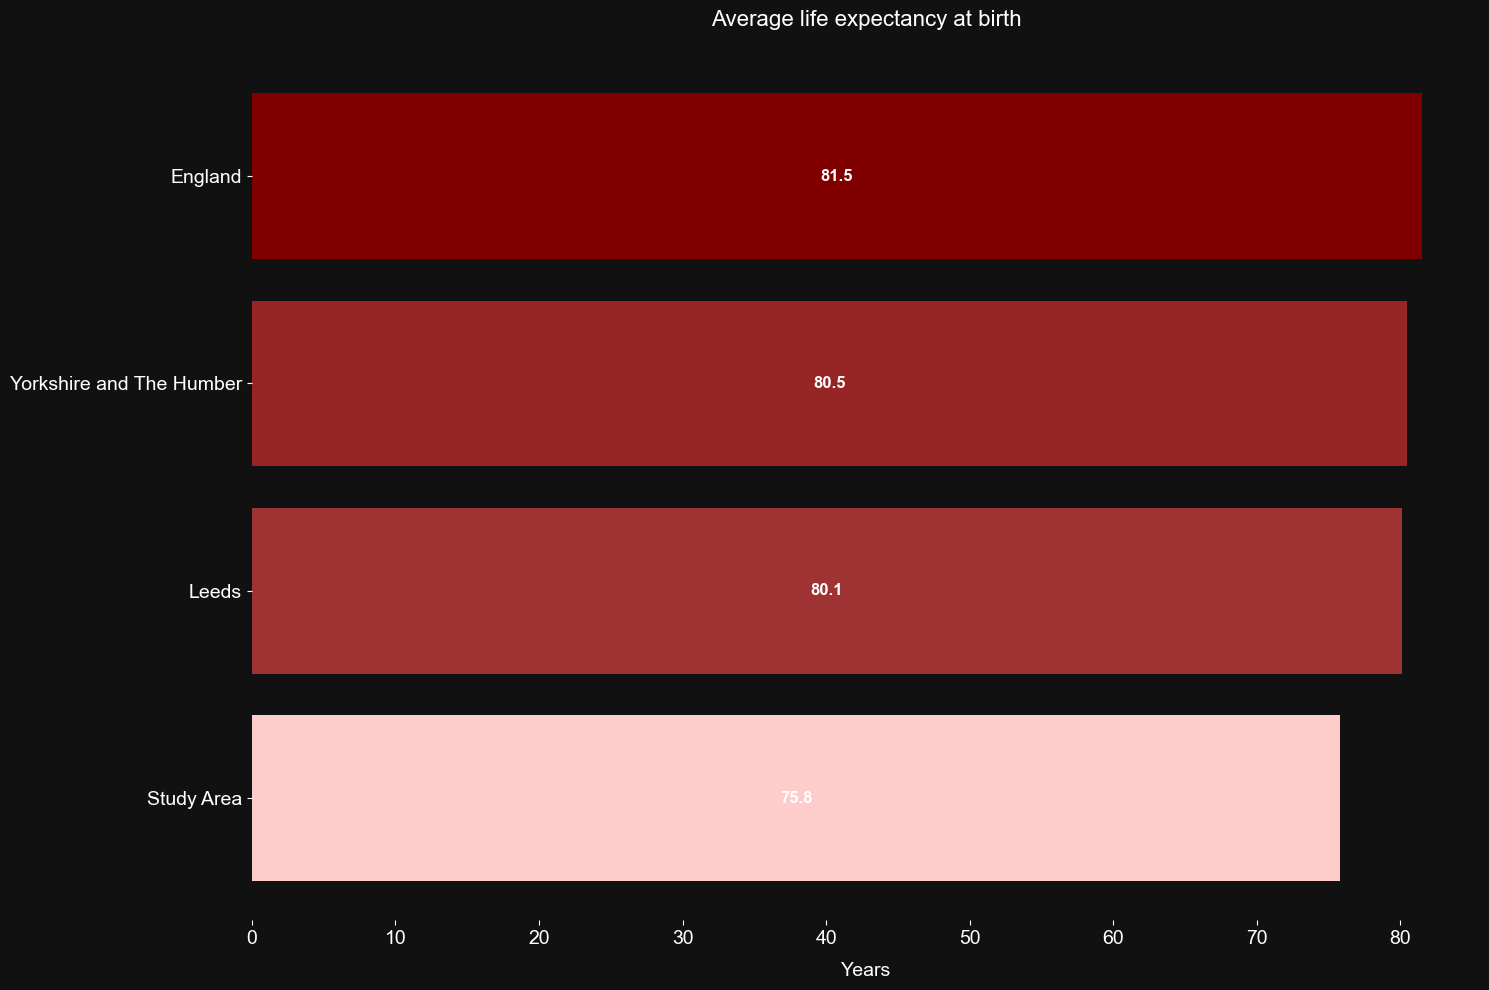

In [74]:
selected_cols = [
    'avg_life_expectancy',
        ]

plot_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Average life expectancy at birth',
    x_axis_label='Years',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='upper right',
    legend_location_x=1.0,
    legend_location_y=1.0,
    show_legend=False, 
    text_color='white',
    background_color='#111',
    label_threshold=0,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Average life expectancy at birth.png',
    dpi=300
)

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Average female life expectancy at birth.png


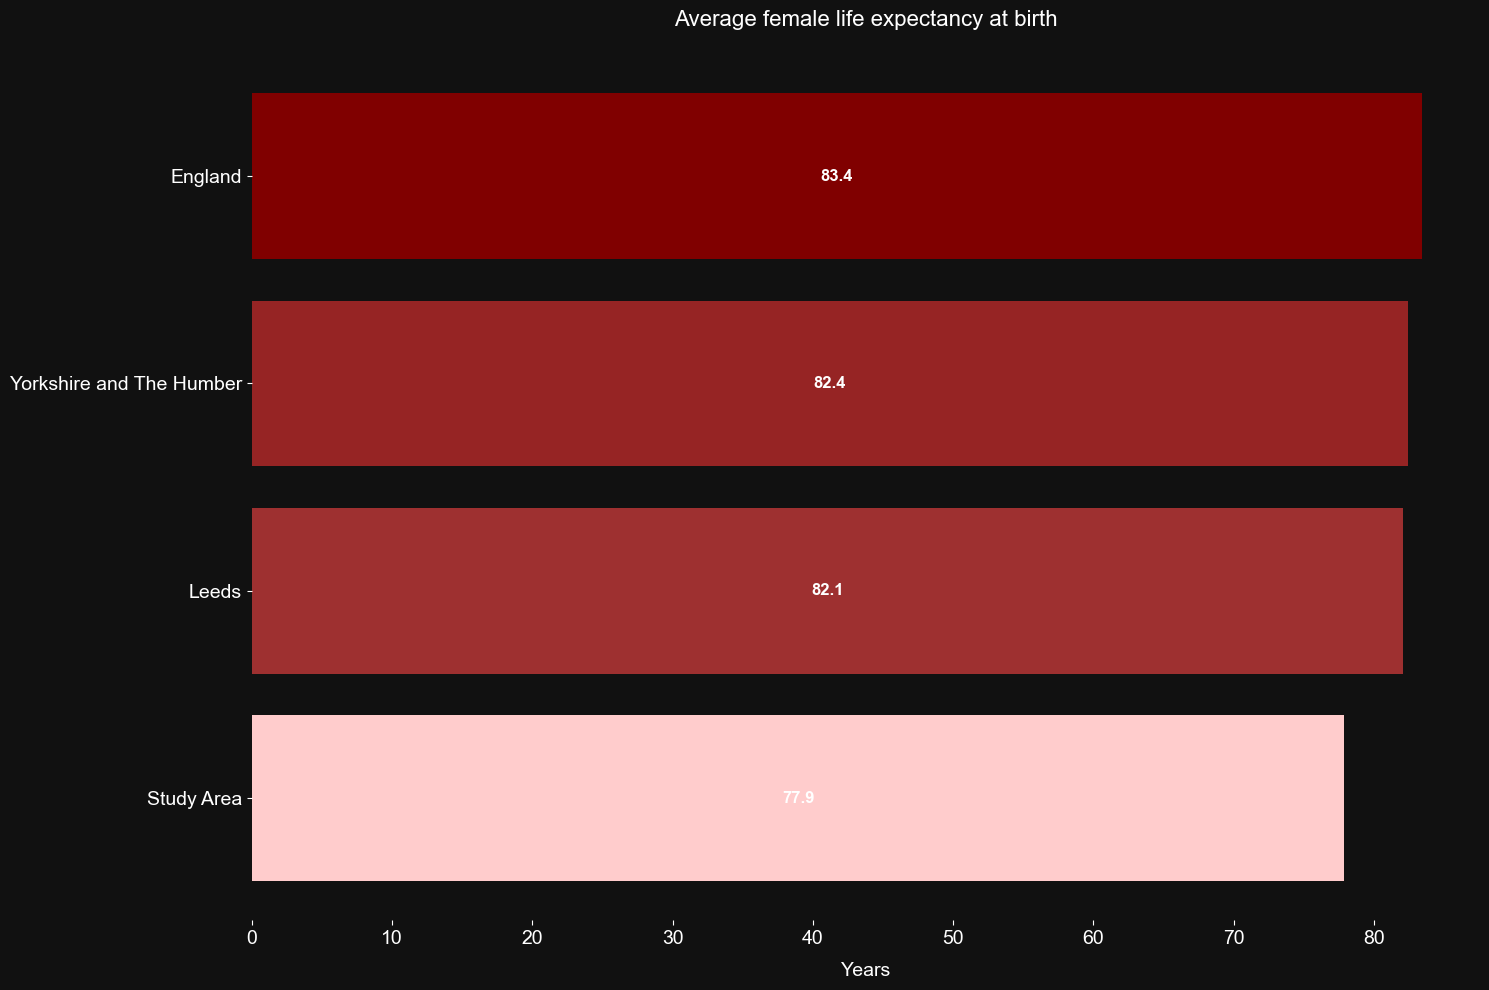

In [75]:
selected_cols = [
    'female_life_expectancy',
        ]

plot_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Average female life expectancy at birth',
    x_axis_label='Years',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='upper right',
    legend_location_x=1.0,
    legend_location_y=1.0,
    show_legend=False, 
    text_color='white',
    background_color='#111',
    label_threshold=0,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Average female life expectancy at birth.png',
    dpi=300
)

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Average male life expectancy at birth.png


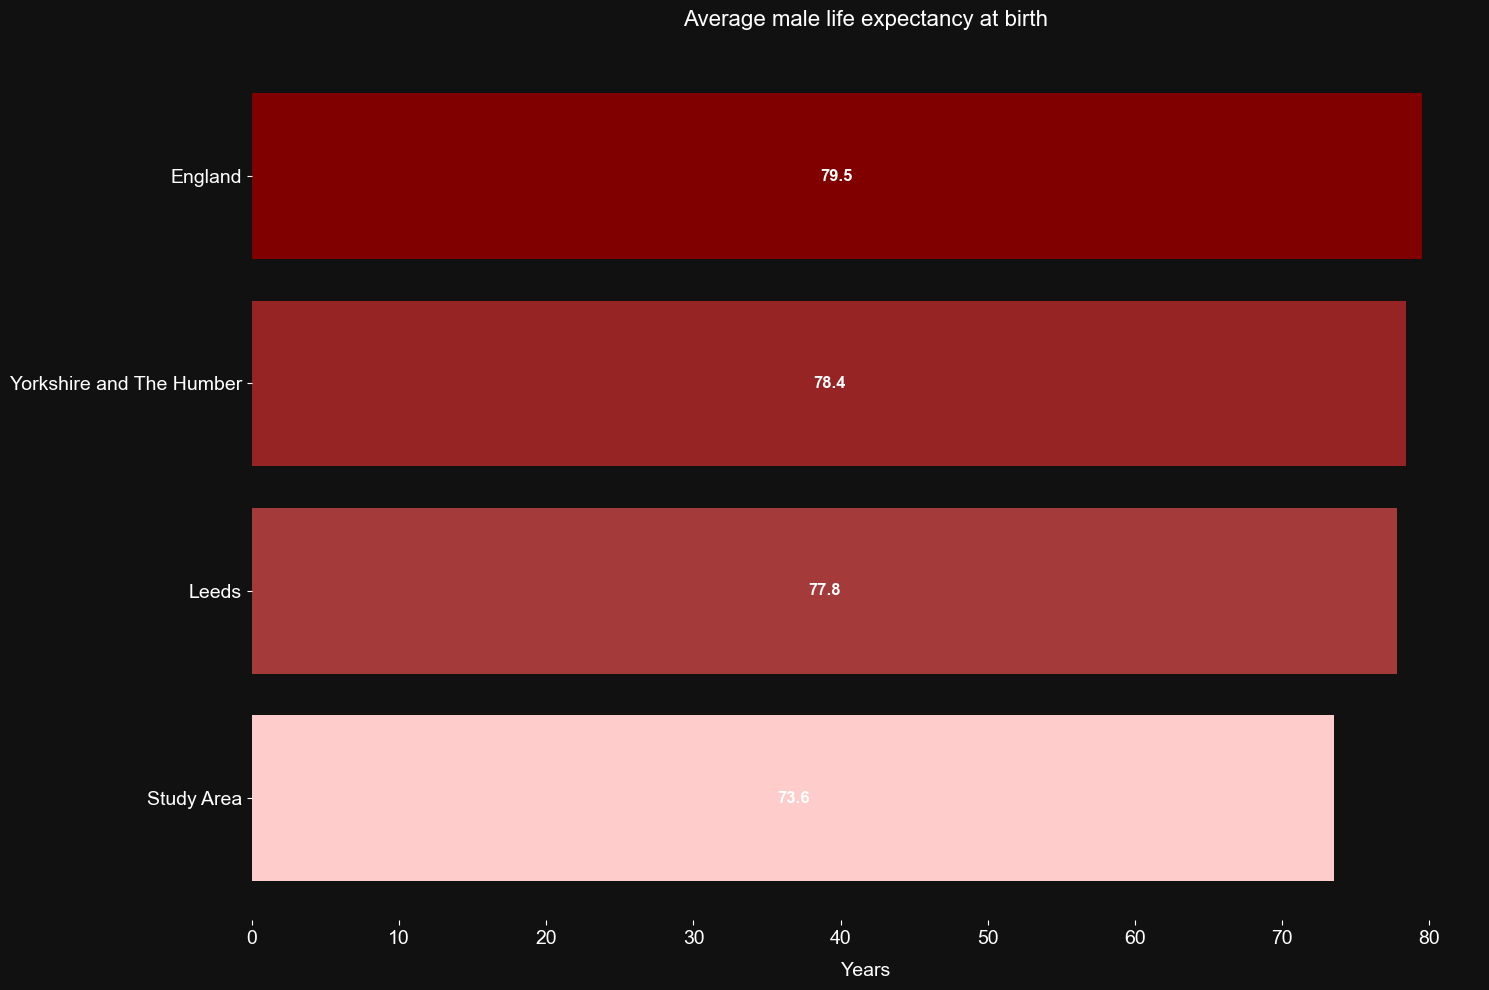

In [76]:
selected_cols = [
    'male_life_expectancy',
        ]

plot_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Average male life expectancy at birth',
    x_axis_label='Years',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='upper right',
    legend_location_x=1.0,
    legend_location_y=1.0,
    show_legend=False, 
    text_color='white',
    background_color='#111',
    label_threshold=0,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Average male life expectancy at birth.png',
    dpi=300
)

# Mortality

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Study area mortality chart.png


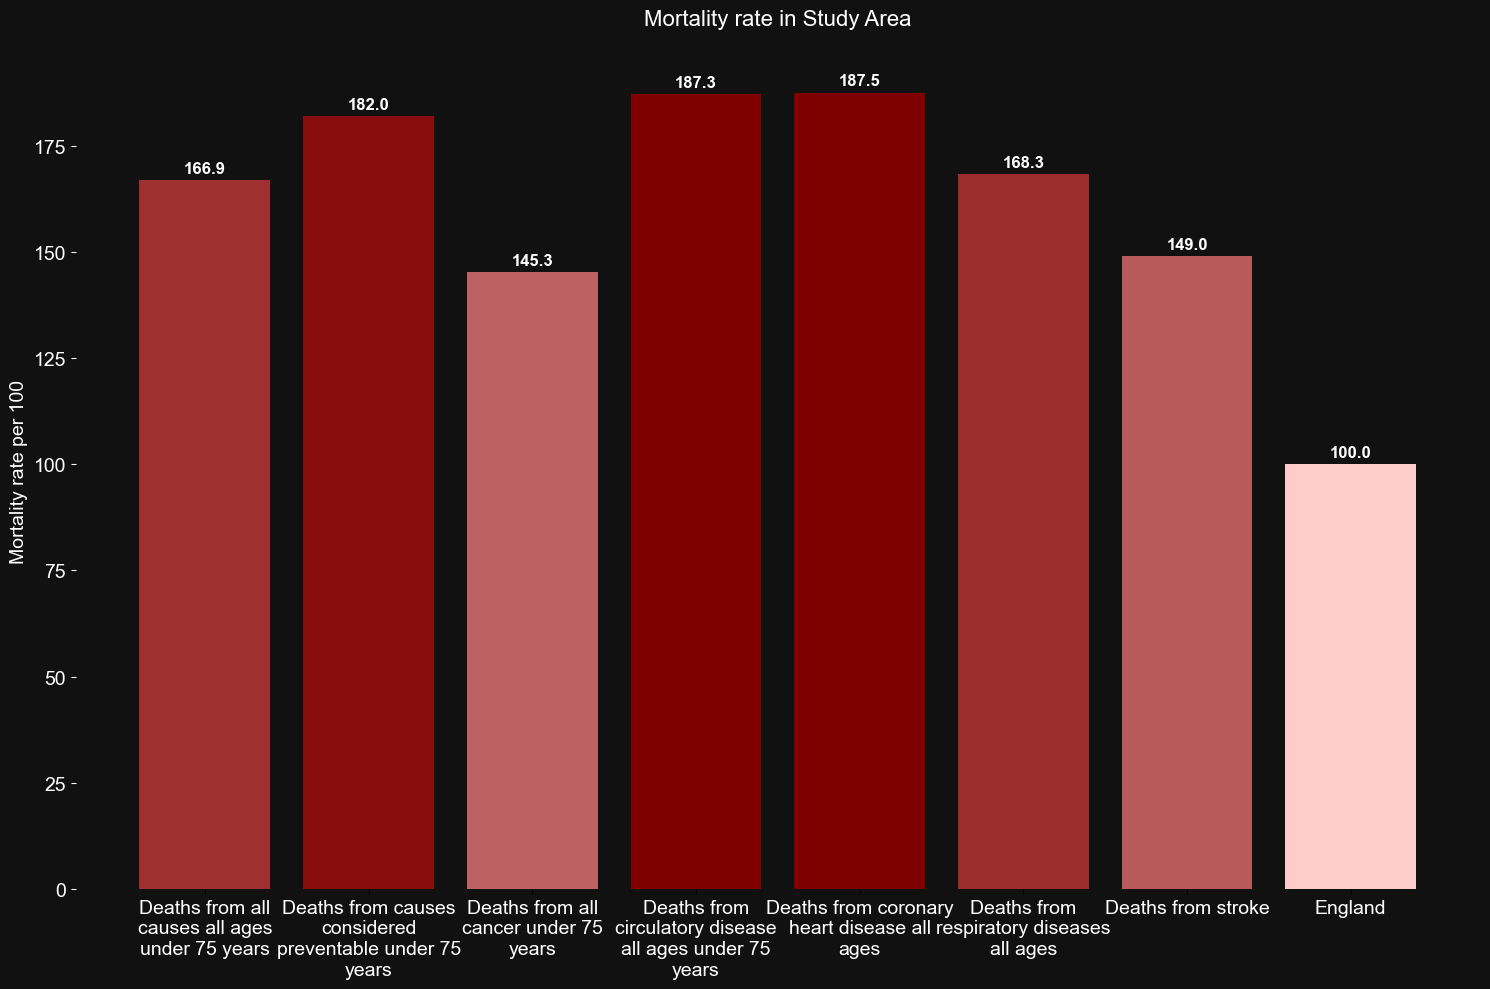

In [123]:
plot_mortality_rate_bar_chart(
    df=study_area_df,
    count_denominator_pairs=[
        ('deaths_from_all_causes_all_ages_under_75_years_count', 'deaths_from_all_causes_all_ages_under_75_years_denominator'),
        ('deaths_from_causes_considered_preventable_under_75_years_count', 'deaths_from_causes_considered_preventable_under_75_years_denomi'),
        ('deaths_from_all_cancer_under_75_years_count', 'deaths_from_all_cancer_under_75_years_denominator'),
        ('deaths_from_circulatory_disease_all_ages_under_75_years_count', 'deaths_from_circulatory_disease_all_ages_under_75_years_denomin'),
        ('deaths_from_coronary_heart_disease_all_ages_count', 'deaths_from_coronary_heart_disease_all_ages_denominator'),
        ('deaths_from_respiratory_diseases_all_ages_count', 'deaths_from_respiratory_diseases_all_ages_denominator'),
        ('deaths_from_stroke_count', 'deaths_from_stroke_denominator')
    ],
    chart_title='Mortality rate in Study Area',
    x_axis_label='',
    y_axis_label='Mortality rate per 100',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title='',
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.15,
    show_legend=False,
    text_color='white',
    background_color='#111',
    label_threshold=1,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Study area mortality chart.png'
)


# Childhood Obesity

🧮 Calculating: (year_6_prevalence_of_obesity_count) / (year_6_prevalence_of_obesity_denominator) × 100
✅ Study Area: 27.42
✅ Leeds: 23.57
✅ Yorkshire and The Humber: 24.17
✅ England: 22.74
📸 Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Childhood Obesity in Year 6 Children.png


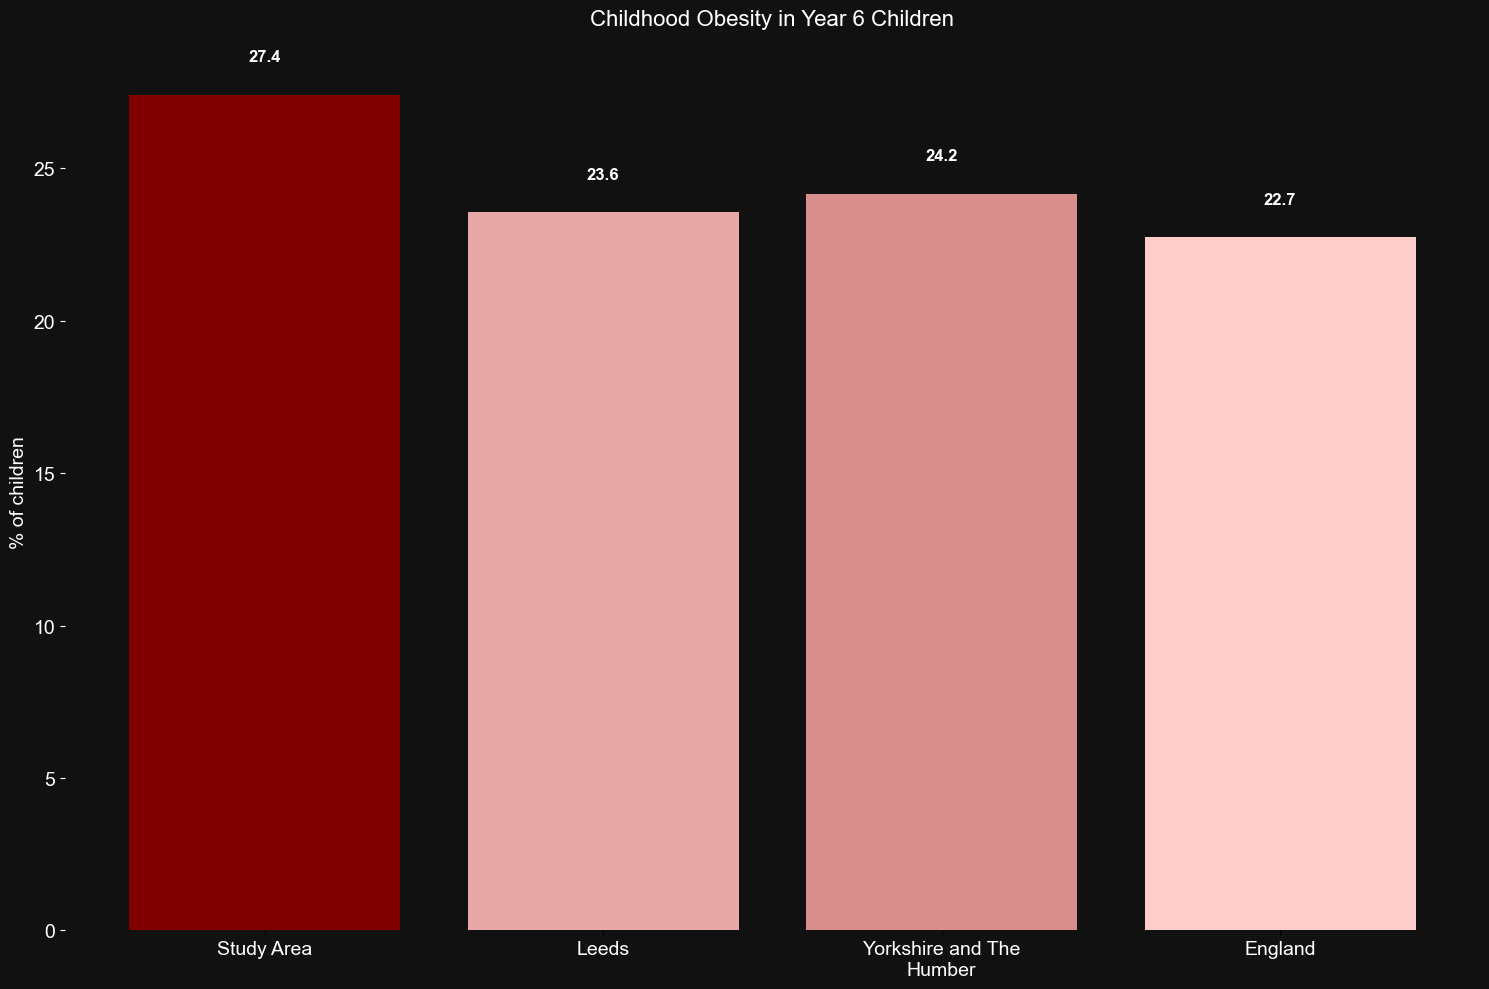

In [119]:
count_col = 'year_6_prevalence_of_obesity_count'
denom_col = 'year_6_prevalence_of_obesity_denominator'

plot_mortality_rate_across_geographies(
    study_area_df,
    leeds_df,
    region_df,
    england_df,
    count_col,
    denom_col,
    area_labels=['Study Area', 'Leeds', 'Yorkshire and The Humber', 'England'],
    chart_title='Childhood Obesity in Year 6 Children',
    x_axis_label='',
    y_axis_label='% of children',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title='',
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.15,
    show_legend=False,
    text_color='white',
    background_color='#111',
    label_threshold=1,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Childhood Obesity in Year 6 Children.png',
    dpi=300
)

🧮 Calculating: (year_6_prevalence_of_overweight_count) / (year_6_prevalence_of_overweight_denominator) × 100
✅ Study Area: 42.94
✅ Leeds: 37.74
✅ Yorkshire and The Humber: 38.22
✅ England: 36.71
📸 Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Overweight children in Year 6.png


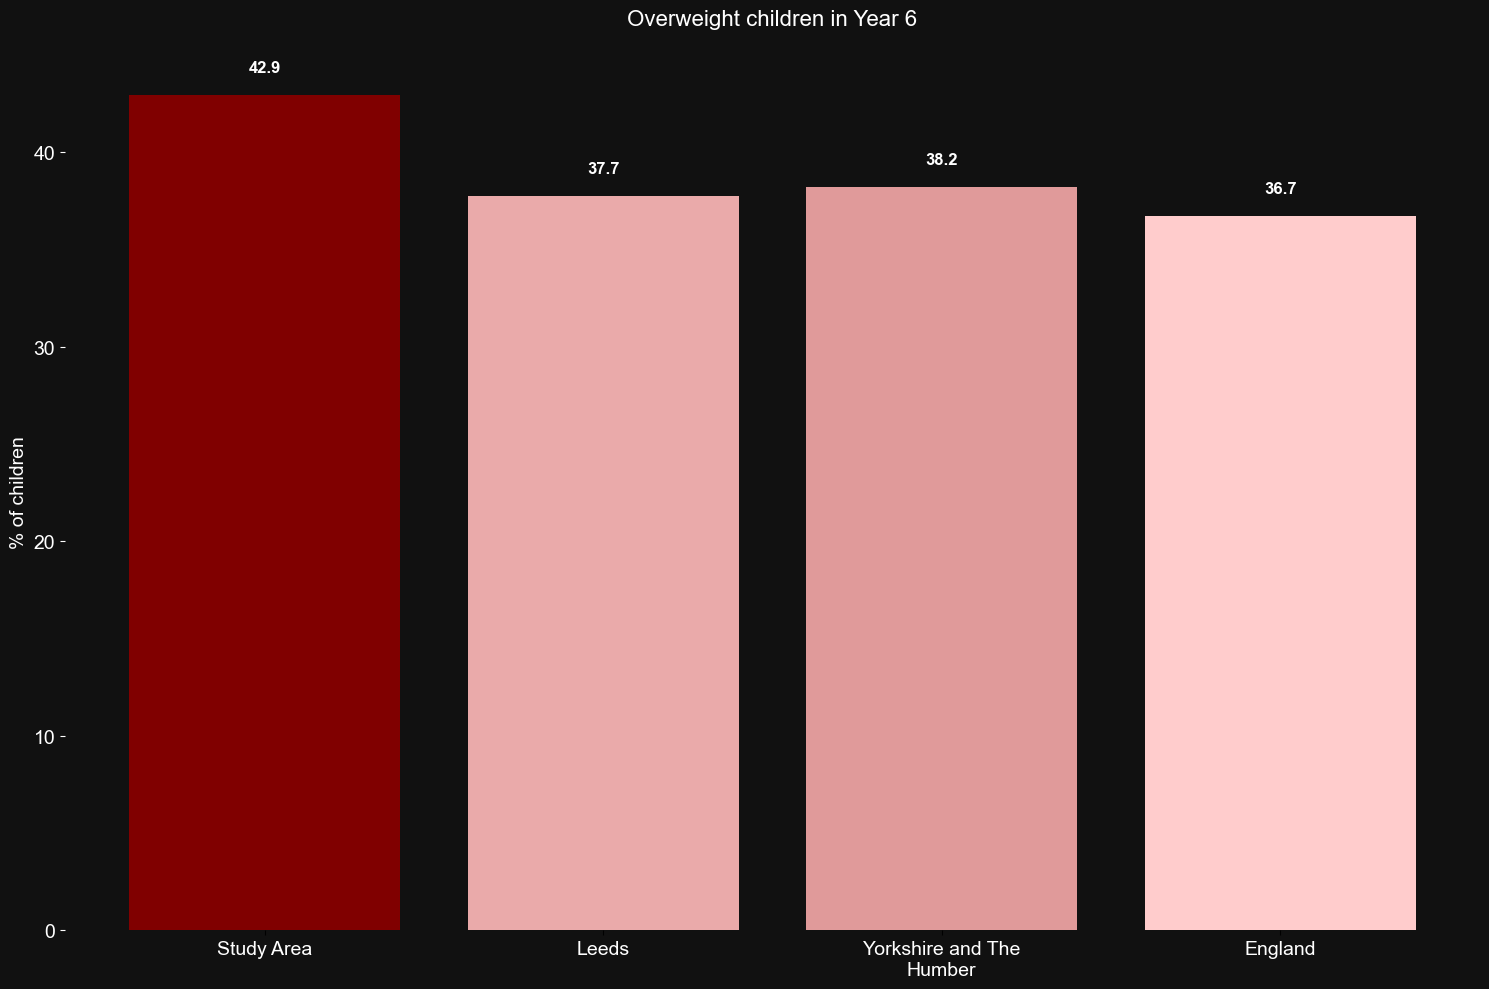

In [124]:
count_col = 'year_6_prevalence_of_overweight_count'
denom_col = 'year_6_prevalence_of_overweight_denominator'

plot_mortality_rate_across_geographies(
    study_area_df,
    leeds_df,
    region_df,
    england_df,
    count_col,
    denom_col,
    area_labels=['Study Area', 'Leeds', 'Yorkshire and The Humber', 'England'],
    chart_title='Overweight children in Year 6',
    x_axis_label='',
    y_axis_label='% of children',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title='',
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.15,
    show_legend=False,
    text_color='white',
    background_color='#111',
    label_threshold=1,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Overweight children in Year 6.png',
    dpi=300
)


# Disability and Disease

🧮 Calculating: (limiting_long_term_illness_or_disability_count) / (limiting_long_term_illness_or_disability_denominator) × 100
✅ Study Area: 12.43
✅ Leeds: 16.72
✅ Yorkshire and The Humber: 18.81
✅ England: 17.64
📸 Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Long term disability and illness.png


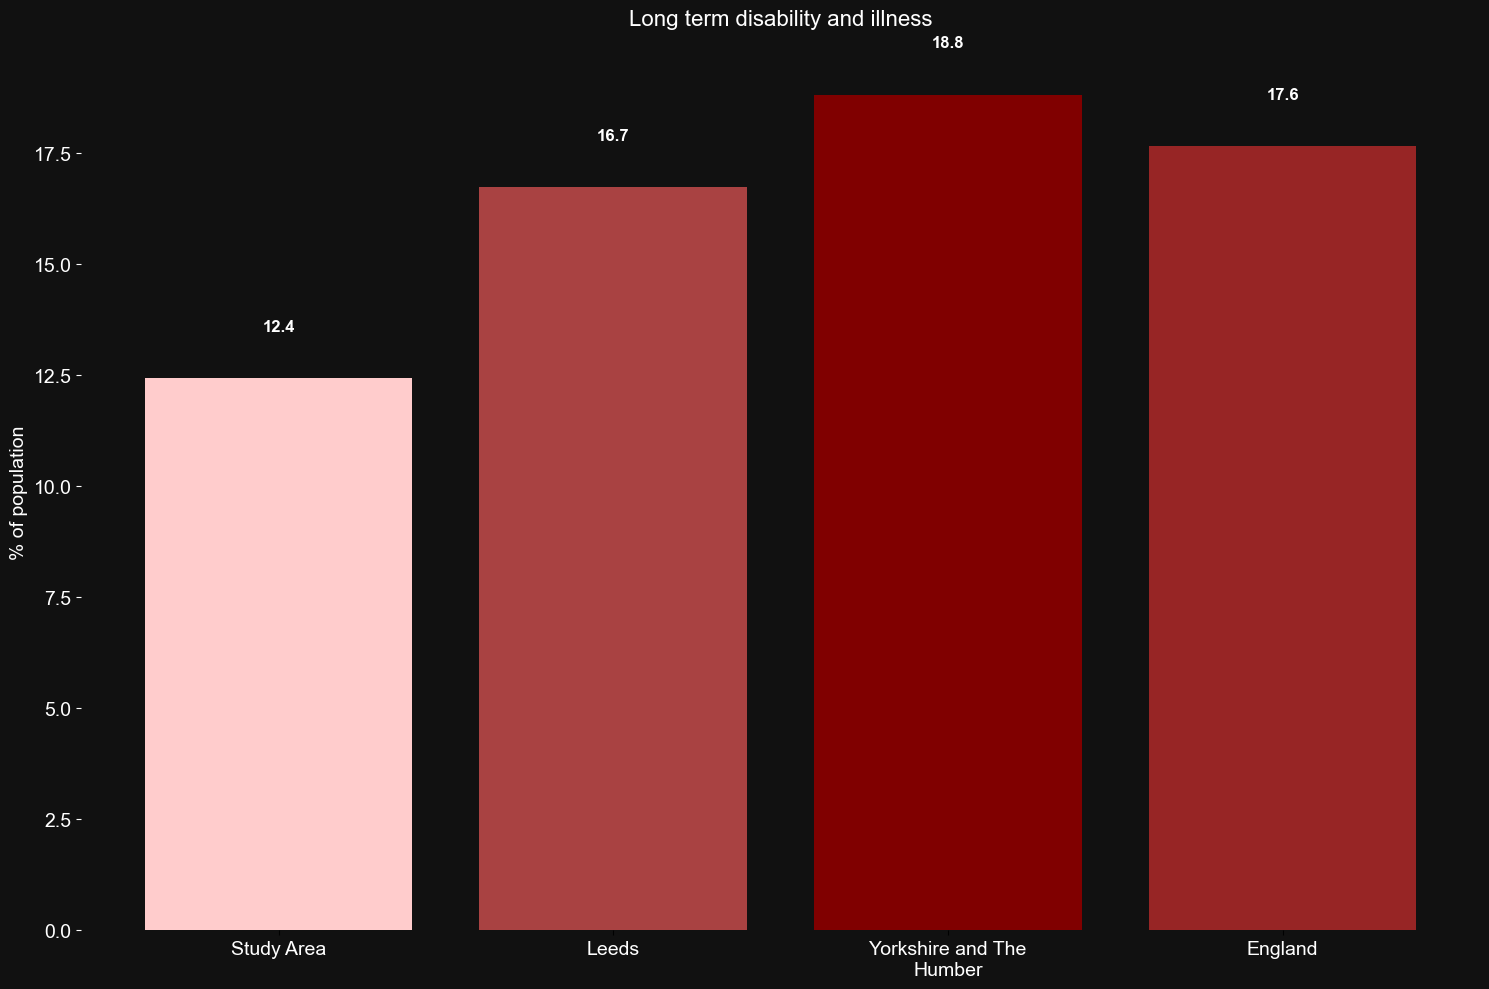

In [144]:
count_col = 'limiting_long_term_illness_or_disability_count'
denom_col =  'limiting_long_term_illness_or_disability_denominator'

plot_mortality_rate_across_geographies(
    study_area_df,
    leeds_df,
    region_df,
    england_df,
    count_col,
    denom_col,
    area_labels=['Study Area', 'Leeds', 'Yorkshire and The Humber', 'England'],
    chart_title='Long term disability and illness',
    x_axis_label='',
    y_axis_label='% of population',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title='',
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.15,
    show_legend=False,
    text_color='white',
    background_color='#111',
    label_threshold=1,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Long term disability and illness.png',
    dpi=300
)


# Unemployment

🧮 Calculating: (unemployment_count) / (unemployment_denominator) × 100
✅ Study Area: 5.86
✅ Leeds: 5.55
✅ Yorkshire and The Humber: 5.24
✅ England: 5.02
📸 Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Unemployment.png


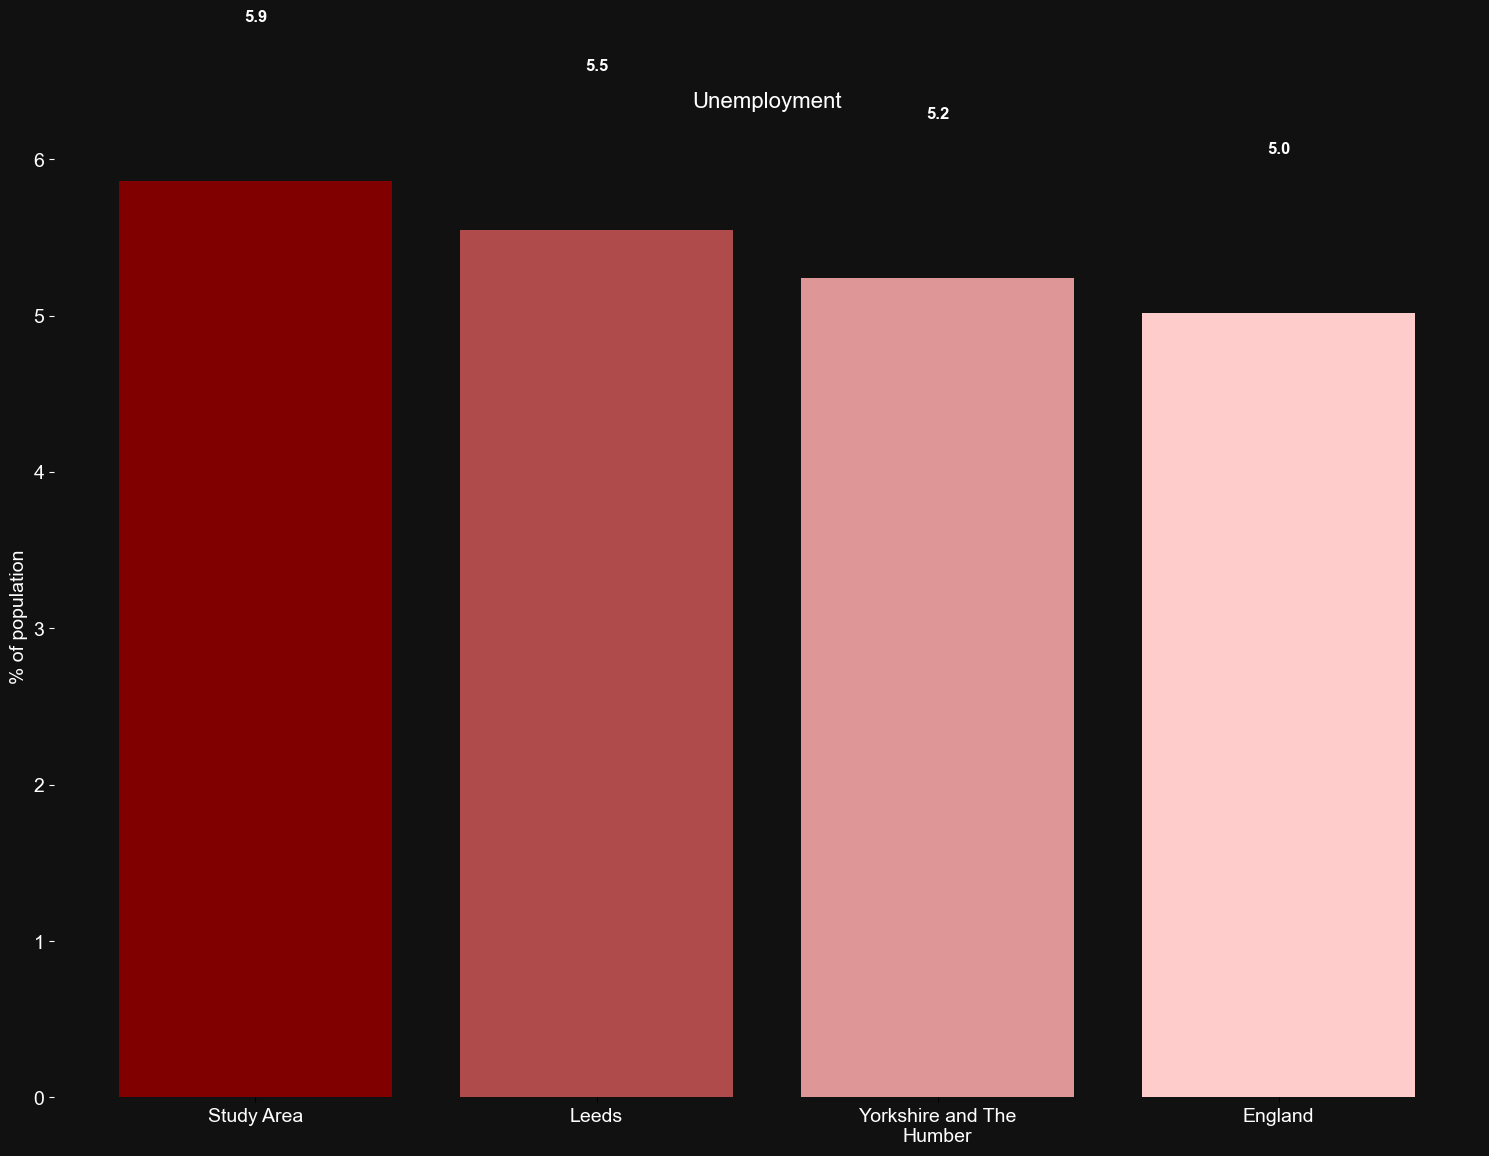

In [160]:
count_col = 'unemployment_count'
denom_col =   'unemployment_denominator'

plot_mortality_rate_across_geographies(
    study_area_df,
    leeds_df,
    region_df,
    england_df,
    count_col,
    denom_col,
    area_labels=['Study Area', 'Leeds', 'Yorkshire and The Humber', 'England'],
    chart_title='Unemployment',
    x_axis_label='',
    y_axis_label='% of population',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title='',
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=0,
    legend_location='upper left',
    legend_location_x=1,
    legend_location_y=1,
    show_legend=False,
    text_color='white',
    background_color='#111',
    label_threshold=1,
    image_width=15,
    image_height=15,
    save_image=True,
    image_path=image_path,
    image_name='Unemployment.png',
    dpi=300
)


🧮 Calculating: (long_term_unemployment_count) / (long_term_unemployment_denominator) × 100
✅ Study Area: 0.40
✅ Leeds: 0.33
✅ Yorkshire and The Humber: 0.26
✅ England: 0.19


C:\Users\abhimanya.achara\AppData\Local\Temp\ipykernel_12232\3837904753.py:121: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


📸 Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Long term unemployment.png


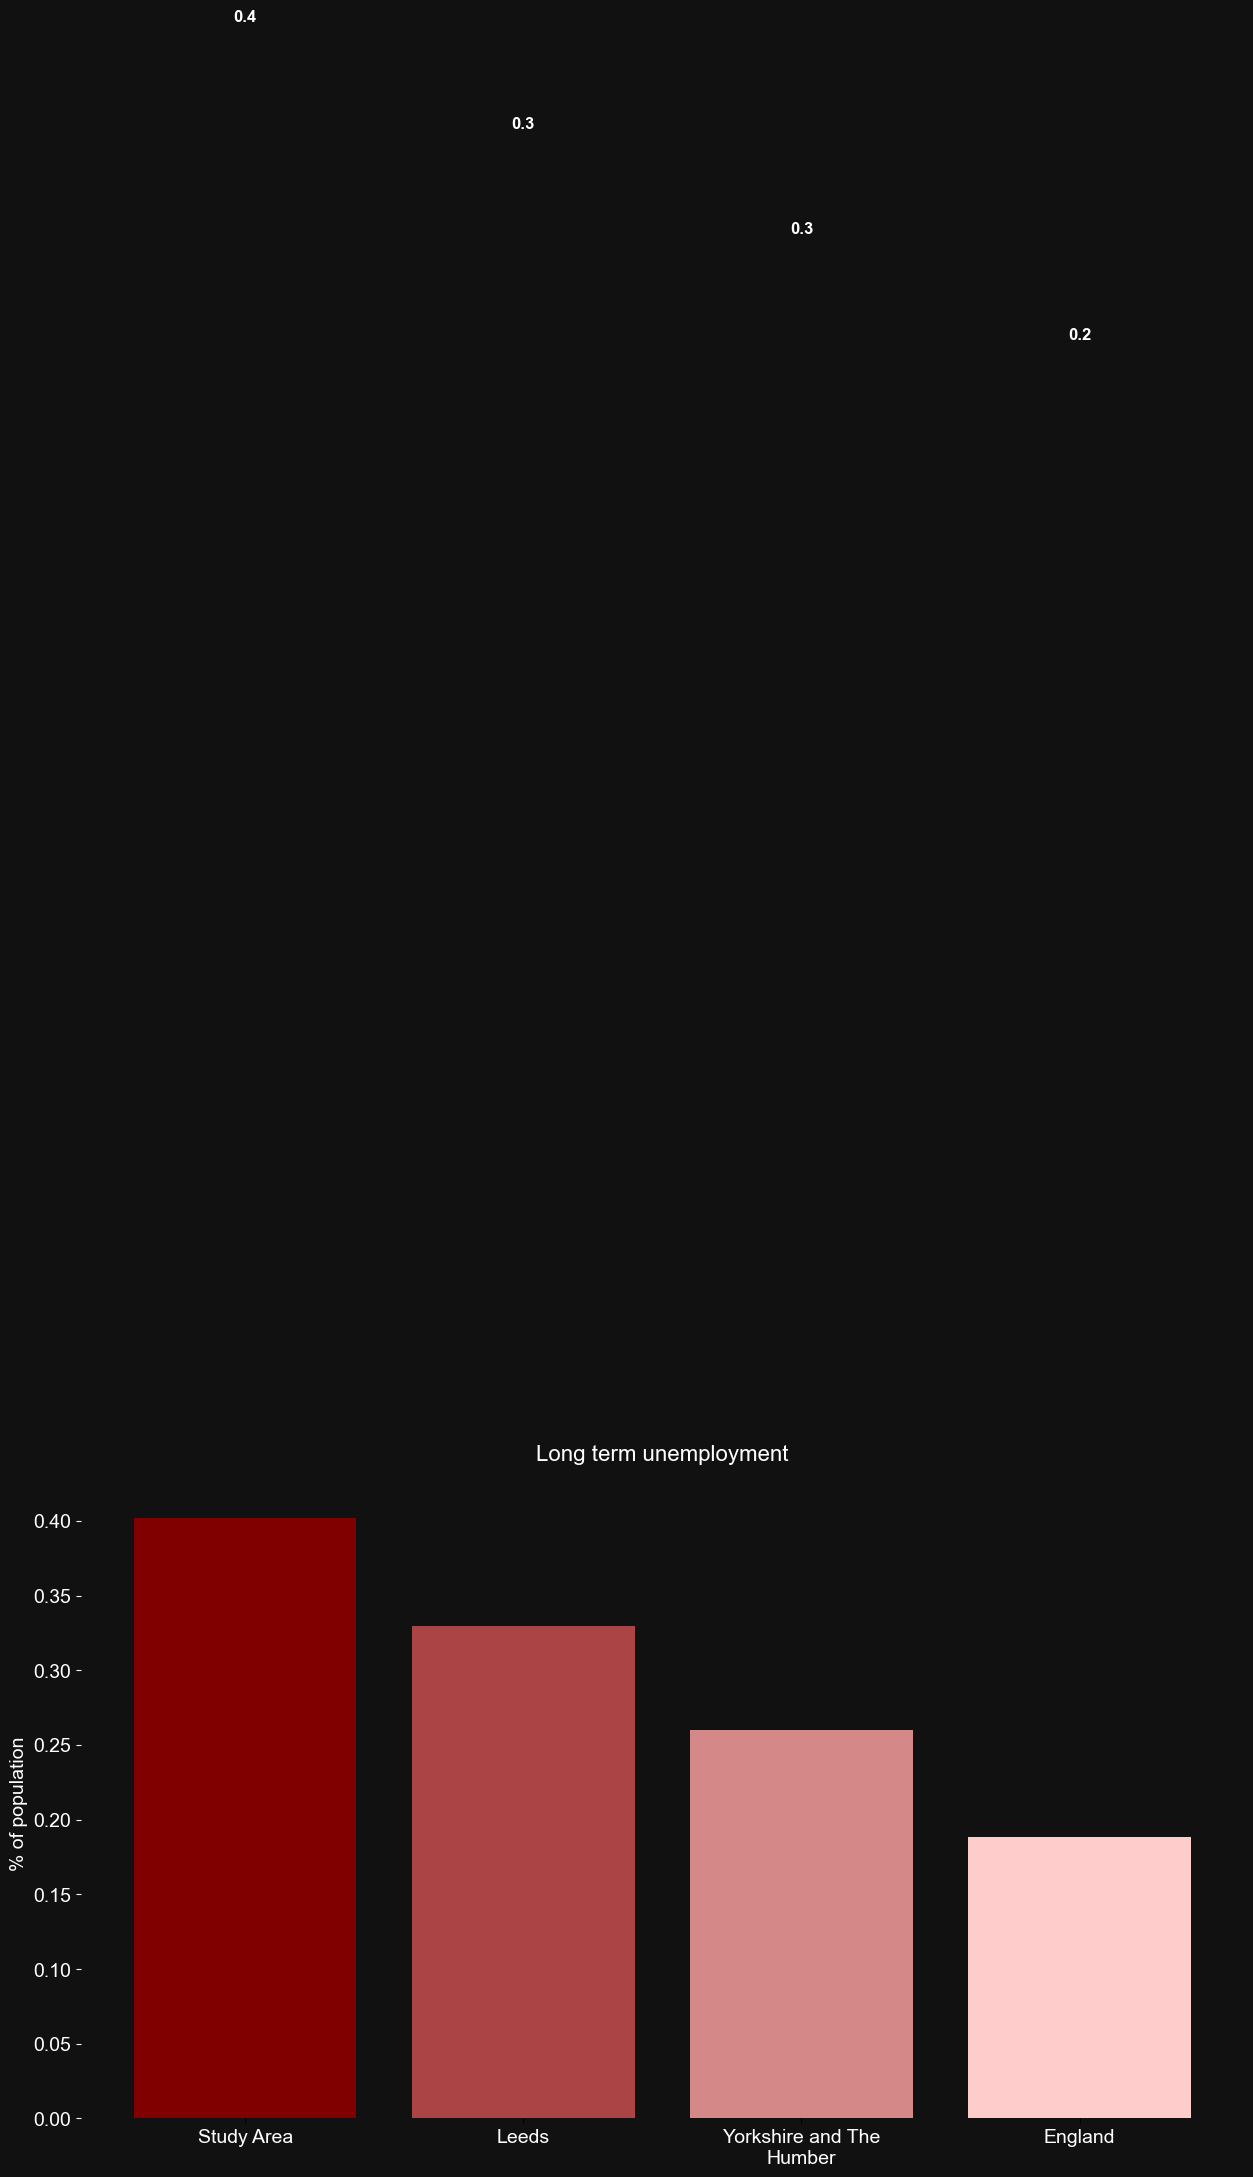

In [161]:
count_col = 'long_term_unemployment_count'
denom_col =   'long_term_unemployment_denominator'

plot_mortality_rate_across_geographies(
    study_area_df,
    leeds_df,
    region_df,
    england_df,
    count_col,
    denom_col,
    area_labels=['Study Area', 'Leeds', 'Yorkshire and The Humber', 'England'],
    chart_title='Long term unemployment',
    x_axis_label='',
    y_axis_label='% of population',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title='',
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.15,
    show_legend=False,
    text_color='white',
    background_color='#111',
    label_threshold=0.1,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Long term unemployment.png',
    dpi=300
)
